In [43]:
%load_ext autoreload
%autoreload 2

import gc
import copy

import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import evaluate

from transformers import (
    T5Tokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)

from src.model_new import (
    T5EncoderModelForTokenClassification,
    create_datasets,
)
import src.config
import src.data
import src.model_new


import peft
from peft import (
    LoraConfig,
    PeftModel
)

import random

print("Base Model:\t", src.config.base_model_name)
print("MPS:\t\t", torch.backends.mps.is_available())
ROOT = src.utils.get_project_root_path()
print("Path:\t\t", ROOT)
device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(f"Using device:\t {device}")

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# torch.set_printoptions(threshold=10_000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Base Model:	 Rostlab/prot_t5_xl_uniref50
MPS:		 True
Path:		 /Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction
Using device:	 mps


In [2]:
t5_tokenizer = T5Tokenizer.from_pretrained(
        pretrained_model_name_or_path=src.config.base_model_name,
        do_lower_case=False,
        use_fast=True,
        legacy=False
    )

In [3]:
t5_base_model = T5EncoderModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=src.config.base_model_name,
    device_map='auto',
    load_in_8bit=False,
    custom_num_labels=len(src.config.label_decoding),
    custom_dropout_rate=0.1,
    )

Some weights of T5EncoderModelForTokenClassification were not initialized from the model checkpoint at Rostlab/prot_t5_xl_uniref50 and are newly initialized: ['custom_classifier.bias', 'custom_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
adapter_location = '/models/testing_13'

# model = T5EncoderModelForTokenClassification.from_pretrained(adapter_location)

# t5_lora_model_reloaded = PeftModel.from_pretrained(
#     model = t5_base_model,
#     is_trainable=False,
#     model_id=ROOT+adapter_location,
#     custom_num_labels=len(src.config.label_decoding),
#     custom_dropout_rate=0.1,
# )
t5_base_model.load_adapter(ROOT+adapter_location)

---

In [141]:
FASTA_FILENAME = '5_SignalP_5.0_Training_set.fasta'
# FASTA_FILENAME = '5_SignalP_5.0_Training_set_testing.fasta'
annotations_name = 'Label' # Choose Type or Label

df_data = src.data.process(src.data.parse_file(ROOT + '/data/raw/' + FASTA_FILENAME))

dataset_signalp = src.model_new.create_datasets(
    splits=src.config.splits,
    tokenizer=t5_tokenizer,
    data=df_data,
    annotations_name=annotations_name,
    dataset_size=src.config.dataset_size,
    encoder=src.config.select_encodings[annotations_name],
    )

del df_data

/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/.venv/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/.venv/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [140]:
display(dataset_signalp)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12462
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4149
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4147
    })
})

In [137]:
count = 0
for sublist in dataset_signalp['valid']['labels']:
    for element in sublist:
        if element == 0:
            count += 1

count
# dataset_signalp['test']['labels']

202812

---

In [30]:
_ds_index = 3900
_ds_type = 'test'

_input_ids_test = t5_tokenizer.decode(dataset_signalp[_ds_type][_ds_index]['input_ids'])
_labels_test = torch.tensor(dataset_signalp[_ds_type][_ds_index]['labels'] + [-100]).to(device)
_attention_mask_test = torch.tensor([dataset_signalp[_ds_type][_ds_index]['attention_mask']]).to(device)

_labels_test_decoded = [src.config.label_decoding[x] for x in _labels_test.tolist()[:-1]]
print(_input_ids_test)
print(_labels_test)
print(_labels_test_decoded)
print(_attention_mask_test)

preds = src.model_new.predict_model(
    sequence=_input_ids_test,
    tokenizer=t5_tokenizer,
    model=t5_base_model,
    labels=_labels_test,
    attention_mask=_attention_mask_test,
    device=device,
)

M H S F R L A A A V L P L L L S S C M L G P D H A P P E T P L P E K F S E G A K Q S A G D V A V S A W W D S F S D R T L N Q Y V A S G L D E</s>
tensor([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3, -100],
       device='mps:0')
['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
tensor(

/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/.venv/lib/python3.11/site-packages/transformers/models/t5/tokenization_t5.py:303: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [31]:
_res = src.model_new.translate_logits(preds.logits.cpu().numpy())
print(_res)

['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I']


In [79]:
# pd.read_csv(ROOT + adapter_location + '/training_log.csv')
training_log = pd.read_parquet(ROOT + adapter_location + '/training_log.parquet')

In [126]:
display(training_log)

,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,eval_loss,eval_accuracy_metric,eval_precision_metric,eval_recall_metric,eval_f1_metric,eval_matthews_correlation,eval_confusion_matrix,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,1.7885,9.987163e-05,0.00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
1,1.8233,9.974326e-05,0.00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
2,1.7854,9.961489e-05,0.00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
3,1.8064,9.948652e-05,0.01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
4,1.7842,9.935815e-05,0.01,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,0.0254,2.567394e-07,1.00,777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
777,0.0868,1.283697e-07,1.00,778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
778,0.1860,0.000000e+00,1.00,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
779,NaN,NaN,1.00,779,1132.9121,11.0,0.688,6.434037e+15,0.348569,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN


In [120]:
data_cm = np.concatenate(training_log['eval_confusion_matrix'].iloc[-1]).reshape(6, 6)

In [139]:
pd.DataFrame(data_cm)[0].sum()

202812

Text(50.722222222222214, 0.5, 'Predicted')

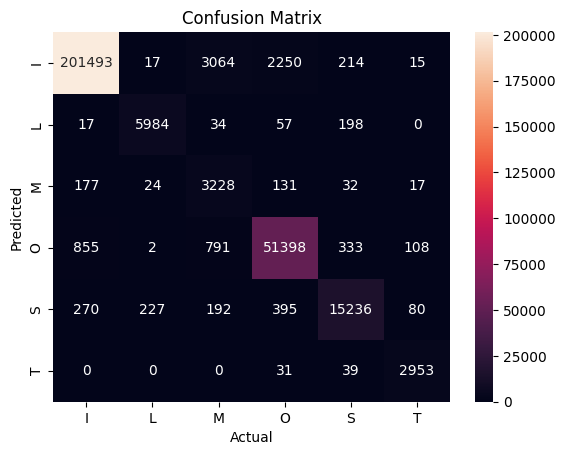

In [125]:
ax = sns.heatmap(
    data_cm,
    annot=True,
    xticklabels=[src.config.label_decoding[label] for label in range(len(src.config.label_decoding))],
    yticklabels=[src.config.label_decoding[label] for label in range(len(src.config.label_decoding))],
    fmt='d'
    )

ax.set_title('Confusion Matrix')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

In [66]:
# for index, (param_name, param) in enumerate(t5_base_model.named_parameters()):
#     # if index == 11:
#     #     break
#     if param.requires_grad:
#         print(param_name)
#     # print(param)
#     if param_name in ['custom_classifier.bias', 'custom_classifier.weight']:
#         print(param)

In [ ]:
# type(t5_base_model)

In [ ]:
# [x for x in t5_base_model.custom_classifier.parameters()]

In [ ]:
# t5_base_model.custom_classifier.weight